In [1]:
import xarray as xr
from datetime import datetime, timedelta
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import os
from netCDF4 import Dataset
from data.datasets import RYDLDataset
import h5py
from matplotlib import pyplot as plt
import wradlib as wrl

In [78]:
data_dir = "../data/RYDL/"
idx = 10

dataset = RYDLDataset(data_dir, var="test")
train, target = dataset.__getitem__(idx)
x,y,t = dataset.get_coordinates()
date = dataset.get_date(idx)
print(date)

2021-05-01T14:40:00.000000000


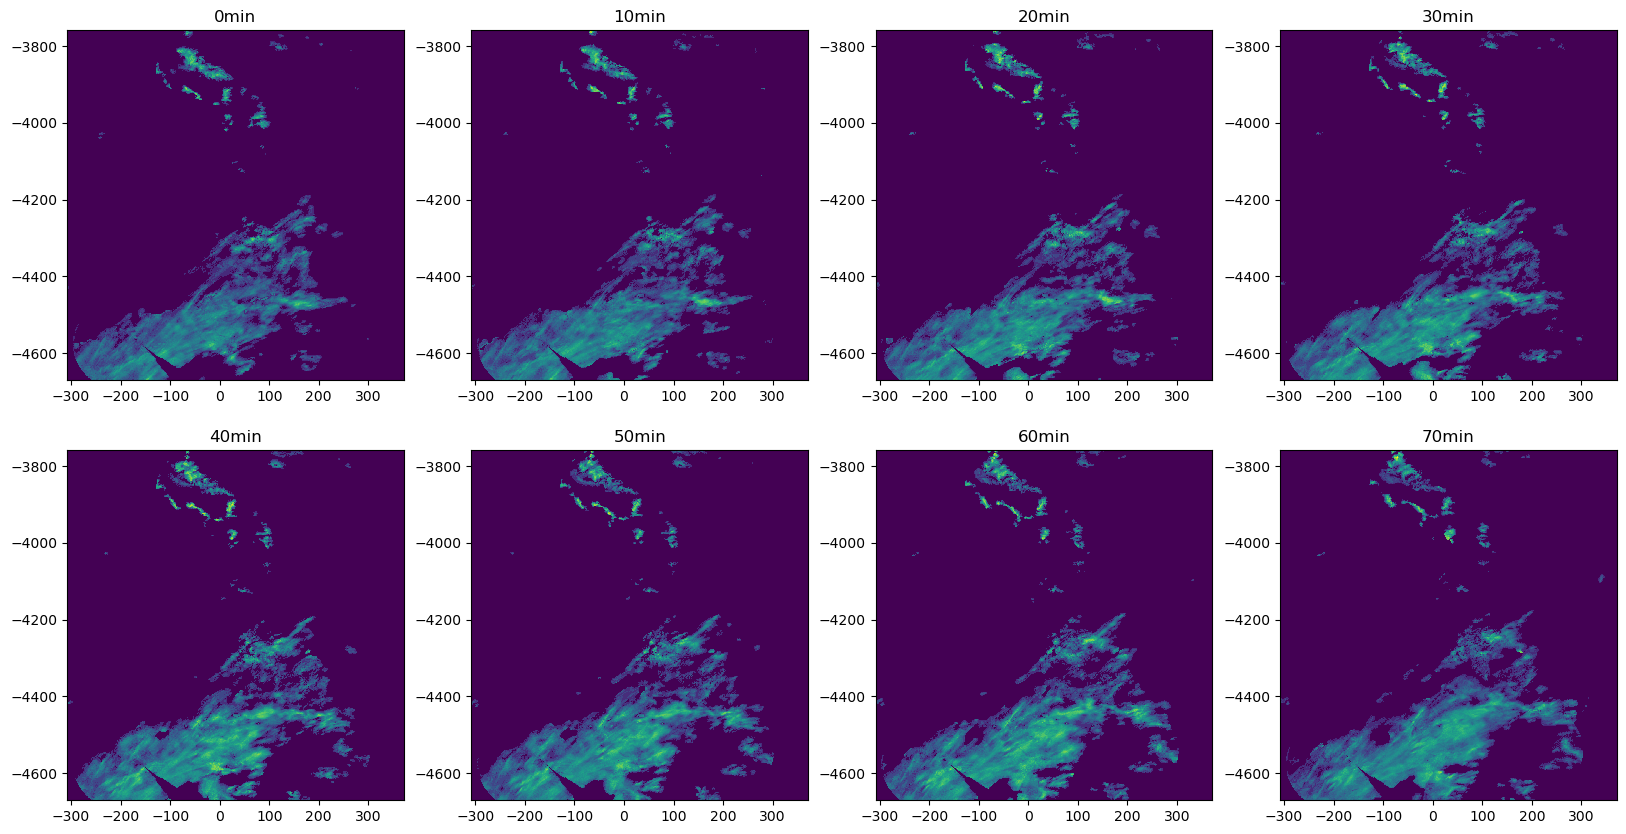

In [79]:
# Plot all precipitation fields

fig, axs = plt.subplots(2,4, figsize = (20,10))
axs = axs.ravel()
for i in range(8):
    axs[i].pcolormesh(x,y, train[0,i])
    axs[i].set_title(f"{t[i]}min")


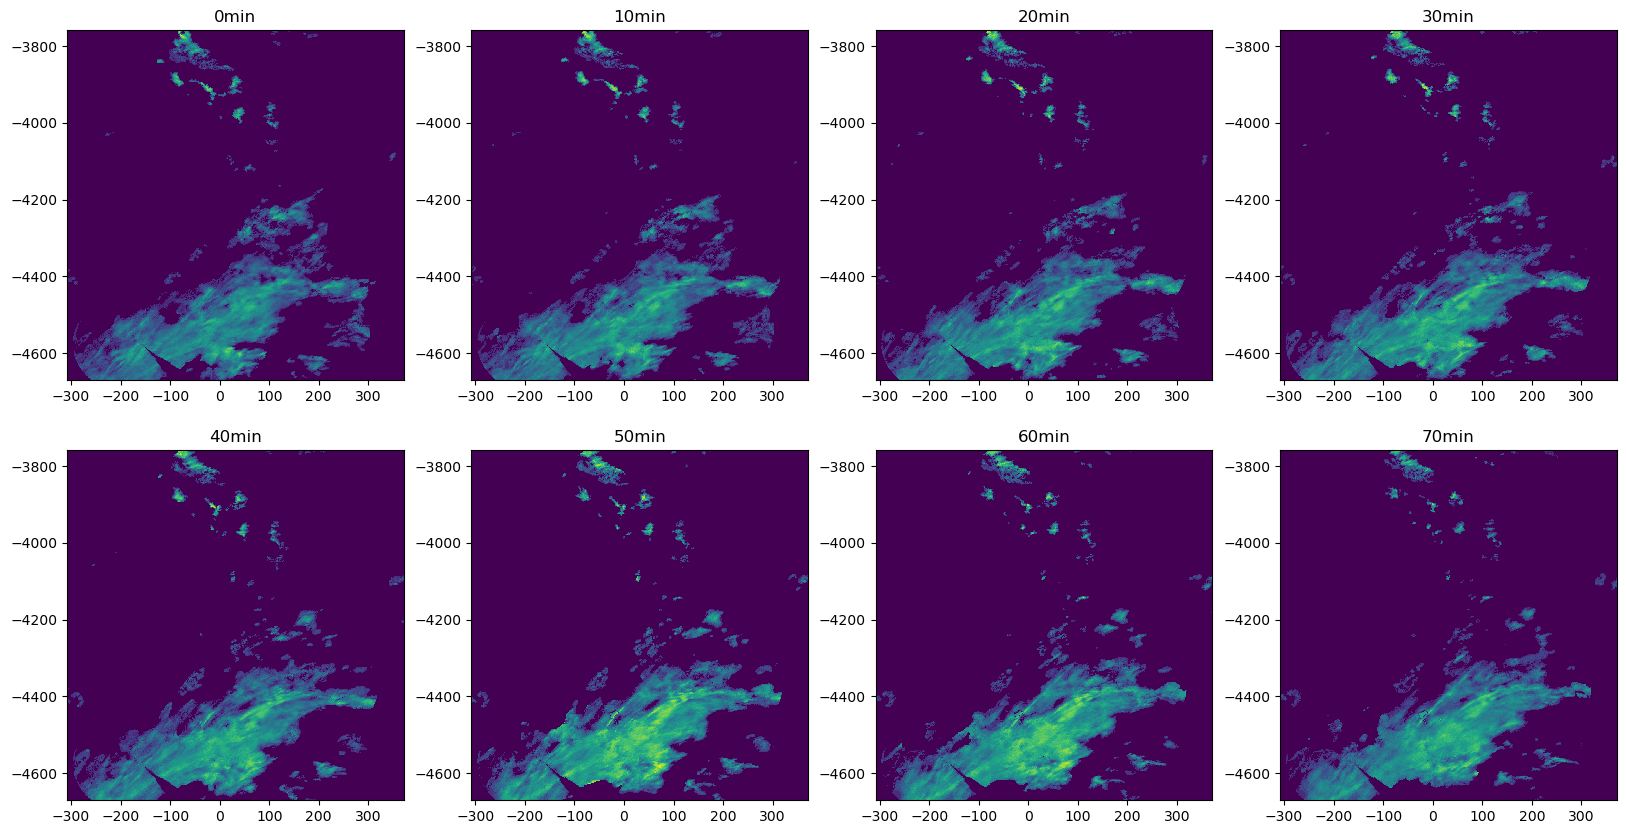

In [80]:
# Plot all precipitation fields

fig, axs = plt.subplots(2,4, figsize = (20,10))
axs = axs.ravel()
for i in range(8):
    axs[i].pcolormesh(x,y, target[0,i])
    axs[i].set_title(f"{t[i]}min")


In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

map_proj = ccrs.Stereographic(
    true_scale_latitude=60.0, central_latitude=90.0, central_longitude=10.0
)


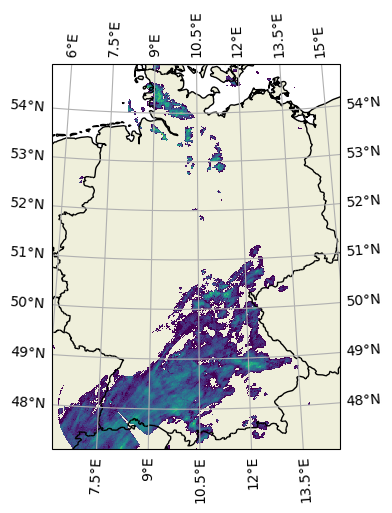

In [82]:
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': map_proj},figsize=(22,5))
#np.log(subset).plot(subplot_kws=dict(projection=map_proj))
train_plot = np.where(train.numpy()< np.log(0.00625+0.01), np.nan, train.numpy())
plt.pcolormesh(x*1000,y*1000, train_plot[0,0])
ax = plt.gca()
ax.gridlines(draw_labels=True, y_inline=False)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

In [3]:
xr_test = xr.open_dataset("../data/RYDL/processed/2021/07/YW_2017.002_20210714.nc").isel(y = slice(88,-100), x = slice(135,-85))
prec = np.log(xr_test.sel(time = date).RR.fillna(0)+0.01)
prec_plot = xr.where(prec< np.log(0.00625+0.01), np.nan, prec)

NameError: name 'date' is not defined

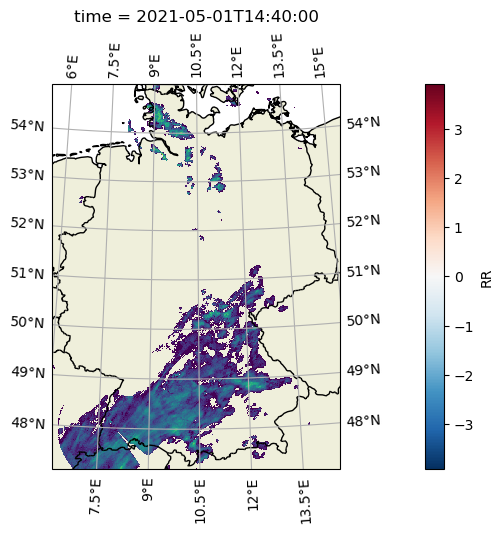

In [87]:
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': map_proj},figsize=(22,5))
prec_plot.plot()
plt.pcolormesh(x*1000,y*1000, train_plot[0,0])
ax = plt.gca()
ax.gridlines(draw_labels=True, y_inline=False)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

In [88]:
comp = np.exp(prec)-0.01
comp2 = np.exp(train[0,0].numpy())-0.01

In [89]:
(comp - comp2).max()

<xarray.DataArray 'RR' ()> Size: 8B
array(5.96046448e-08)
Coordinates:
    time     datetime64[ns] 8B 2021-05-01T14:40:00

In [44]:
radolan_grid_xy = wrl.georef.get_radolan_grid(900, 900, wgs84=True)
x = [radolan_grid_xy[0,0,0], radolan_grid_xy[0,-1,0]]
y = [radolan_grid_xy[0,0,1], radolan_grid_xy[-1,0,1]]
print(x,y)

[3.588929950917963, 14.608702502626649] [46.95258041119031, 54.57904570041962]


In [29]:
radolan_grid_xy = wrl.georef.get_radolan_grid(1100, 900, wgs84=True)
x = [radolan_grid_xy[0,0,0], radolan_grid_xy[0,-1,0]]
y = [radolan_grid_xy[0,0,1], radolan_grid_xy[-1,0,1]]
print(x,y)

[4.675934176579067, 15.468175240935931] [46.19287861255967, 55.53947933382205]


In [14]:
xr_test = xr.open_dataset("../data/RYDL/processed/2021/07/YW_2017.002_20210714.nc").isel(y = slice(88,-100), x = slice(135,-85))

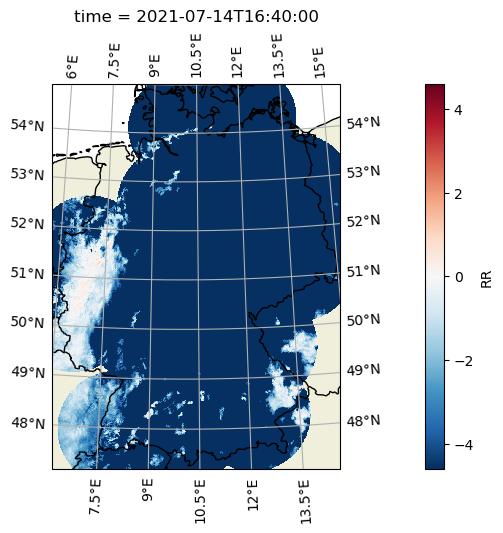

In [19]:
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': map_proj},figsize=(22,5))
np.log(xr_test.isel(time = 200).RR+0.01).plot()
ax = plt.gca()
ax.gridlines(draw_labels=True, y_inline=False)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)